In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsforecast import StatsForecast
from statsforecast.models import CrostonOptimized, ADIDA, TSB

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

D:\Anaconda\lib\site-packages\statsforecast\core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
plt.rcParams["figure.figsize"] = (9,6)

In [4]:
def errors(y_true, y_pred):
    
    # CFE
    cfe_all = np.cumsum(y_true - y_pred)
    cfe = cfe_all.iloc[-1]
    
    cfe_max = np.max(cfe_all)
    cfe_min = np.min(cfe_all)
    
    # PIS
    pis_all = -np.cumsum(cfe_all)
    pis = pis_all.iloc[-1]
    
    # NOS
    nos = len(cfe_all[cfe_all > 0])

    errors = {
        "CFE": cfe,
        "CFE_max": cfe_max,
        "CFE_min": cfe_min,
        "PIS": pis,
        "NOS": nos
    }
    
    return errors

In [21]:
df = pd.read_csv('data/car_parts_monthly_sales.csv')

df['date'] = pd.to_datetime(df['date'])

df.head()

,id,parts_id,date,volume
0,1,2674,1998-01-01,0
1,2,2674,1998-02-01,0
2,3,2674,1998-03-01,0
3,4,2674,1998-04-01,0
4,5,2674,1998-05-01,2


In [22]:
df['parts_id'].unique()

array([2674, 2673, 2672, 2671, 2670, 2669, 2668], dtype=int64)

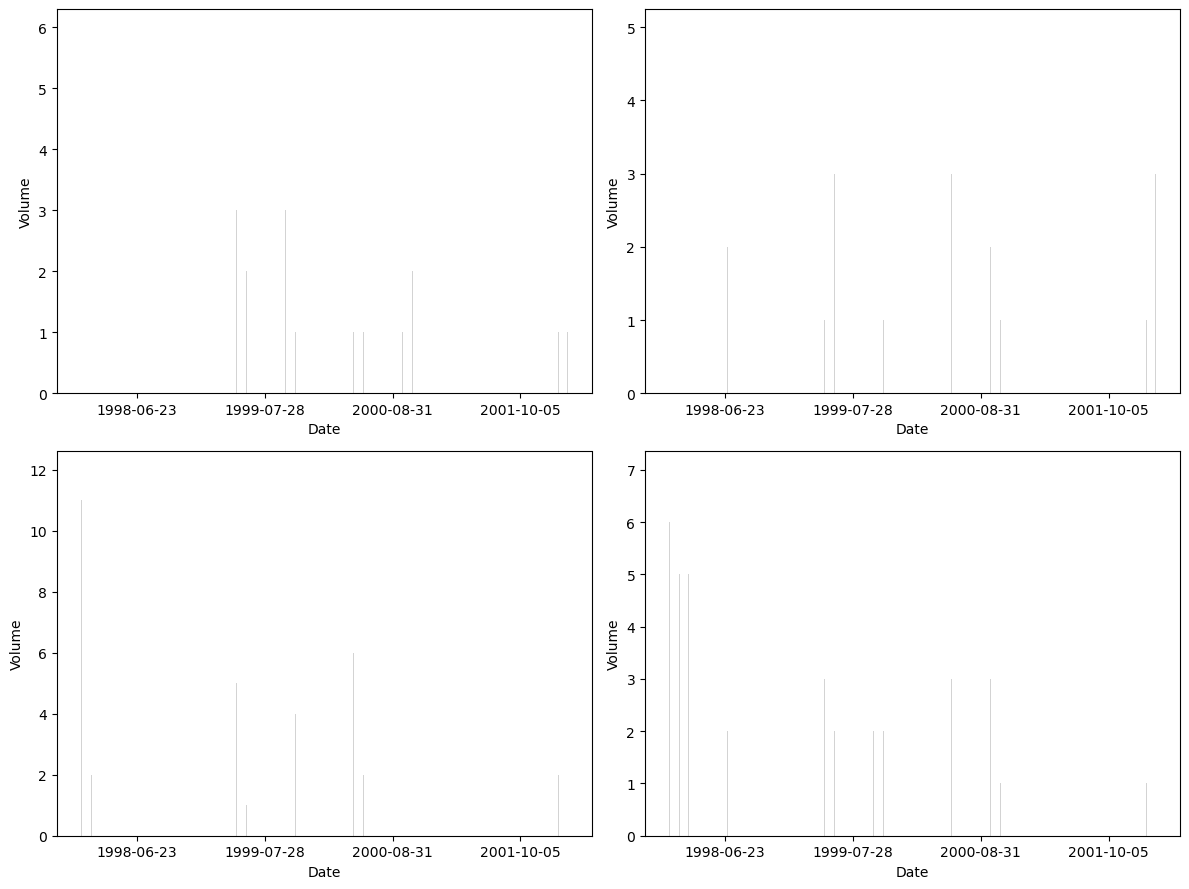

In [23]:
parts_ids = df['parts_id'].unique()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

for i, ax in enumerate(axes.flatten()):
    
    ax.bar(
        x=df[df['parts_id'] == parts_ids[i]]['date'],
        height=df[df['parts_id'] == parts_ids[i]]['volume'],
        color='lightgray'
    )

    ax.set_xlabel('Date')
    ax.set_ylabel('Volume')
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    
plt.tight_layout()

## Forecasting 

In [24]:
model_df = df.drop(['id'], axis=1)
model_df.rename({"parts_id": "unique_id", "date": "ds",
                "volume": "y"}, axis=1, inplace=True)

model_df

,unique_id,ds,y
0,2674,1998-01-01,0
1,2674,1998-02-01,0
2,2674,1998-03-01,0
3,2674,1998-04-01,0
4,2674,1998-05-01,2
...,...,...,...
352,2668,2001-11-01,0
353,2668,2001-12-01,0
354,2668,2002-01-01,1
355,2668,2002-02-01,1


In [27]:
models = [TSB(0.1, 0.1), ADIDA(), CrostonOptimized()]

sf = StatsForecast(
    df=model_df,
    models=models,
    freq='MS',
    n_jobs=-1
)

cv_df = sf.cross_validation(
    df=model_df,
    h=4,
    step_size=4,
    n_windows=3
)

cv_df

,ds,cutoff,y,TSB,ADIDA,CrostonOptimized
unique_id,,,,,,
2668,2001-04-01,2001-03-01,2.0,1.215414,0.707330,0.781058
2668,2001-05-01,2001-03-01,2.0,1.215414,0.707330,0.781058
2668,2001-06-01,2001-03-01,6.0,1.215414,0.707330,0.781058
2668,2001-07-01,2001-03-01,0.0,1.215414,0.707330,0.781058
2668,2001-08-01,2001-07-01,1.0,1.543623,1.877855,2.074792
...,...,...,...,...,...,...
2674,2001-11-01,2001-07-01,2.0,1.204351,0.642959,0.986814
2674,2001-12-01,2001-11-01,2.0,1.084467,0.857275,0.751457
2674,2002-01-01,2001-11-01,0.0,1.084467,0.857275,0.751457


## Evaluation 

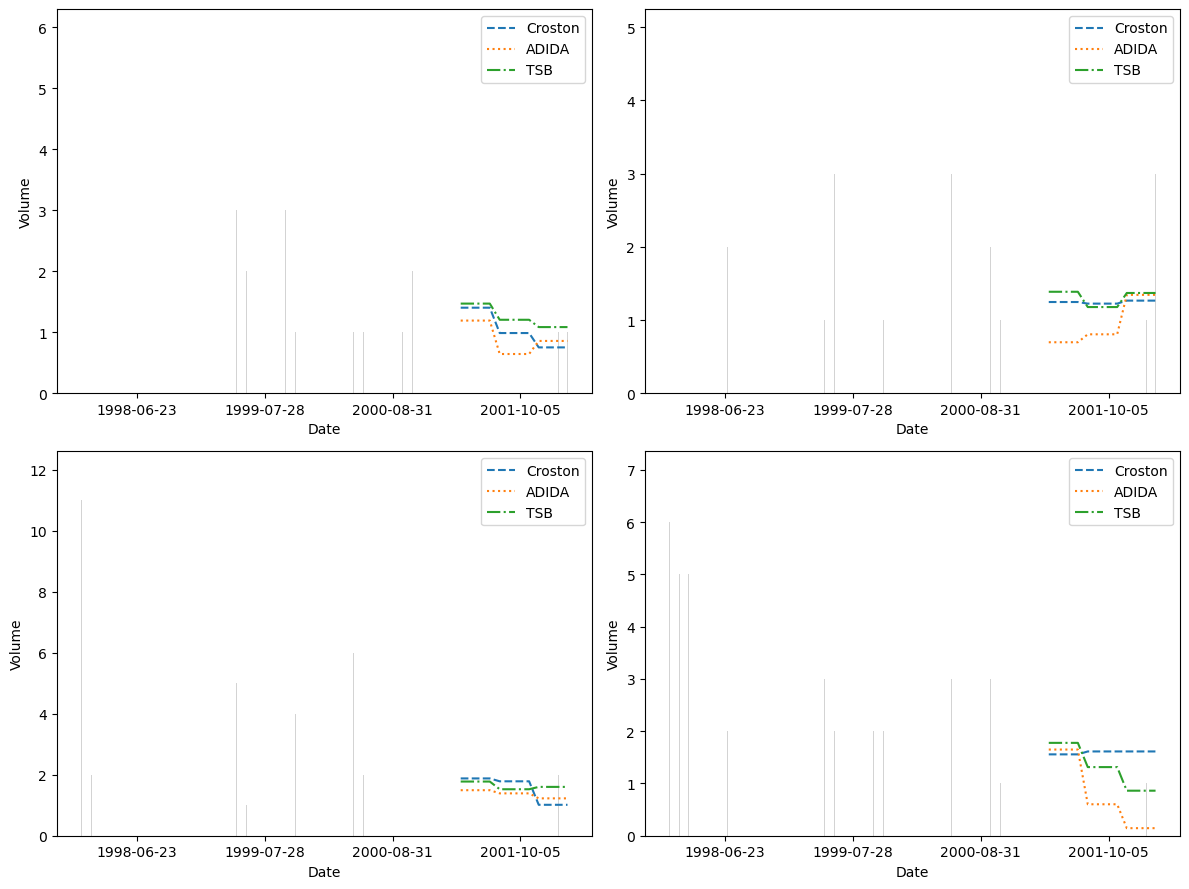

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

for i, ax in enumerate(axes.flatten()):
    
    ax.bar(
        x=df[df['parts_id'] == parts_ids[i]]['date'],
        height=df[df['parts_id'] == parts_ids[i]]['volume'],
        color='lightgray'
    )
    ax.plot(
        cv_df[cv_df.index==parts_ids[i]]['ds'],
        cv_df[cv_df.index==parts_ids[i]]['CrostonOptimized'],
        ls='--',
        label='Croston'
    )
    
    ax.plot(
        cv_df[cv_df.index==parts_ids[i]]['ds'],
        cv_df[cv_df.index==parts_ids[i]]['ADIDA'],
        ls=':',
        label='ADIDA'
    )
    
    ax.plot(
        cv_df[cv_df.index==parts_ids[i]]['ds'],
        cv_df[cv_df.index==parts_ids[i]]['TSB'],
        ls='-.',
        label='TSB'
    )

    ax.set_xlabel('Date')
    ax.set_ylabel('Volume')
    ax.legend(loc='best')
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    
plt.tight_layout()

In [29]:
croston_errors = errors(cv_df['y'], cv_df['CrostonOptimized'])
adida_errors = errors(cv_df['y'], cv_df['ADIDA'])
tsb_errors = errors(cv_df['y'], cv_df['TSB'])

print(croston_errors)
print(adida_errors)
print(tsb_errors)

{'CFE': -41.35299, 'CFE_max': 8.651390075683594, 'CFE_min': -44.09335708618164, 'PIS': 2060.1028, 'NOS': 12}
{'CFE': -5.0277653, 'CFE_max': 9.537116050720215, 'CFE_min': -12.577536582946777, 'PIS': 269.7729, 'NOS': 26}
{'CFE': -34.143932, 'CFE_max': 8.507474899291992, 'CFE_min': -34.601707458496094, 'PIS': 1423.5746, 'NOS': 14}


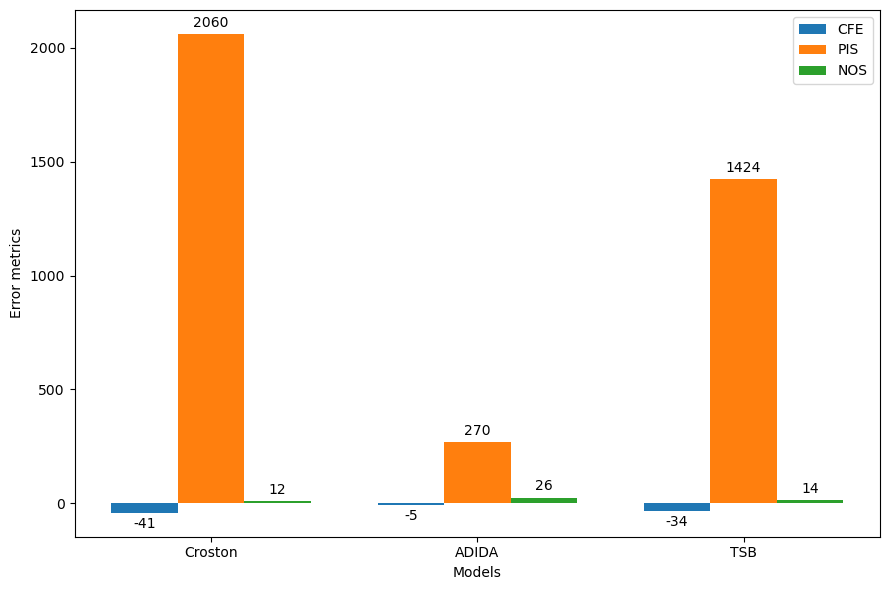

In [34]:
models = ['Croston', 'ADIDA', 'TSB']
errors = {
    'CFE': (-41, -5, -34),
    'PIS': (2060, 270, 1424),
    'NOS': (12, 26, 14)
}

x = np.arange(len(models))
width = 0.25
multiplier = 0

fig, ax = plt.subplots()

for attr, value in errors.items():
    offset = width*multiplier
    rects = ax.bar(x+offset, value, width, label=attr)
    ax.bar_label(rects, padding=3)
    multiplier += 1
    
ax.set_xlabel('Models')
ax.set_ylabel('Error metrics')
ax.set_xticks(x+width, models)
ax.legend(loc='best')

plt.tight_layout()